In [43]:
## This Notebook corresponds to the work on Emperical Robustness

# Imports
import numpy as np
import matplotlib.pyplot as plt
import math

import matplotlib.colors as mcolors
plt.rcParams.update({'font.size': 14})
from matplotlib.patches import Patch

# Functions

In [14]:
# Code for Example matrix 

def generate_example_majority_minority_matrix(m_min, m_maj):
    """
    Constructs a binary preference matrix R as described in the 'Very Simple Majority-Minority Matrix' example.

    Parameters:
        m_min (int): Number of users who like each less popular item
        m_maj (int): Number of users who like each popular item

    Returns:
        R (ndarray): The structured binary preference matrix of shape ((2m_maj + 2m_min), 4)
    """
    # First item liked by m_maj users
    block1 = np.array([[1, 0, 0, 0]] * m_maj)
    
    # Second item liked by m_maj users
    block2 = np.array([[0, 1, 0, 0]] * m_maj)
    
    # Third item liked by m_min users
    block3 = np.array([[0, 0, 1, 0]] * m_min)
    
    # Fourth item liked by m_min users
    block4 = np.array([[0, 0, 0, 1]] * m_min)

    # Stack blocks vertically in the specified order
    R = np.vstack((block1, block2, block3, block4))

    return R

In [27]:
# Code for Algorithm 1 

def find_effective_eta(sigma_k_maj, alpha, n_bar, ASV, AV, kappa, U_EA_size):

    # Upper Bound on feasible eta
    N_upper = min((sigma_k_maj**2 - alpha**2) / (math.sqrt(n_bar) * AV), kappa)

    # Discriminant
    d = n_bar * AV**2 + 4 * U_EA_size * (alpha**2 - ASV)

    if d <= 0:
        # No real eta lower bound exists
        N_lower = N_upper / 2
    else:
        # Lower bound on feasible eta
        N_lower = (math.sqrt(n_bar) * AV + math.sqrt(d)) / (2 * U_EA_size)

        if N_lower < N_upper:
            # Return if feasible eta exists
            return (N_lower + N_upper) / 2
        else:
        # Update upper bound based on alternative discriminant constraint
            N_upper = min(N_upper, (math.sqrt(n_bar) * AV - math.sqrt(d)) / (2 * U_EA_size))

            if N_upper > 0:
                return N_upper / 2

    return 0


In [35]:
# Code for if eta works --- inputs ETA and TRUE paramaters and outputs f(\eta)

def is_eta_EA(eta, sigma_k_maj, U_EA_size, ASV, n_bar, AV, alpha):

    min_value = min(sigma_k_maj**2, eta**2 * U_EA_size + ASV)
    value = min_value - eta*np.sqrt(n_bar)*AV-alpha**2
    return value

# Example

In [40]:
# define matrix and TRUE paramaters --- HALF of majority users uprate, 50 for both Item 1 and 2 users
m_maj = 100
m_min = 10
n_bar = 2
kappa = 1

R = generate_example_majority_minority_matrix(m_min, m_maj)

# parameters that depend on m_maj, m_min
alpha = np.sqrt((m_min+5)) 

sigma_k_maj = np.sqrt(m_maj)
sigma_1_minor = np.sqrt(m_min)

ASV = m_min 
AV = m_maj/2
U_EA_size = m_maj

# This is the TRUE eta for our example
eta_star = find_effective_eta(sigma_k_maj, alpha, n_bar, ASV, AV, kappa, U_EA_size)
print(eta_star)

0.8859417019301559


# Parameter Robustness

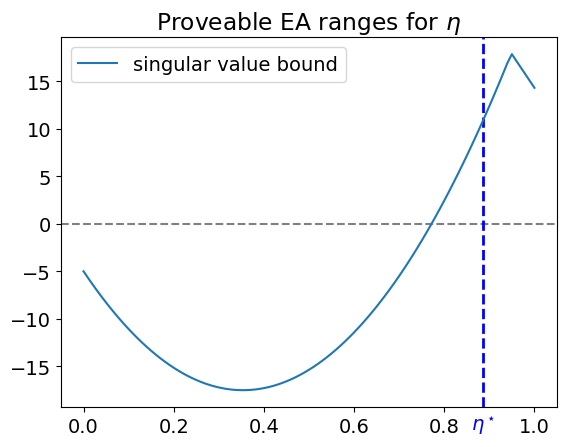

In [41]:
# This is the RANGE of eta in [0,1] that works (we verified the results analytically)
n=100
eta_range = np.linspace(0, 1, n+1)
value_gap = []

for i in range(n+1):
    eta = eta_range[i]
    value_ = is_eta_EA(eta, sigma_k_maj, U_EA_size, ASV, n_bar, AV, alpha)
    value_gap.append(value_)
    
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)
plt.axvline(x=eta_star, color='blue', linestyle='--', linewidth=2)
plt.plot(eta_range,value_gap, label = 'singular value bound')
plt.title('Proveable EA ranges for $\eta$')
plt.text(eta_star, -20, r'$\eta^\star$', ha='center', va='top', color='blue', fontsize=14)
plt.legend()
plt.savefig('Desktop/proveable_EA_ranges.png')

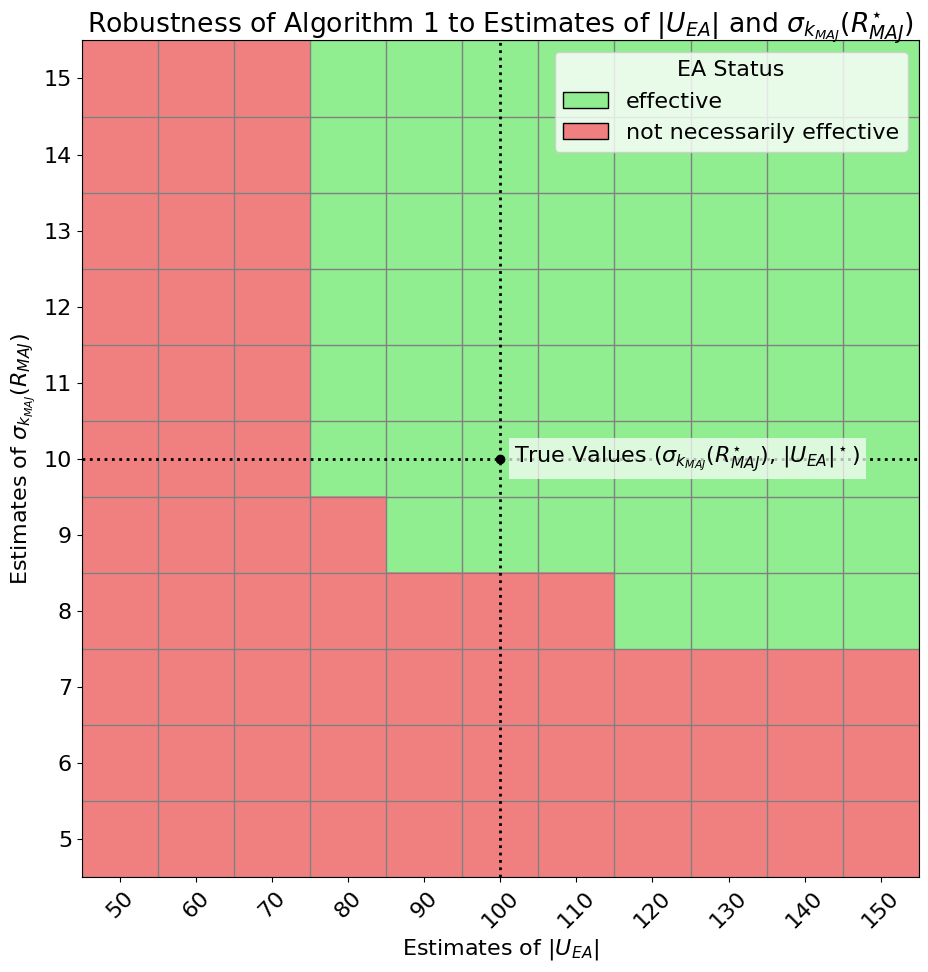

In [89]:
# Create 11 values for U_EA and sigma_k_maj ranges (centered around TRUE values)
plt.rcParams.update({'font.size': 16})

U_EA_range = np.linspace(50, 150, 11,dtype=int)
sigma_range = np.linspace(5, 15, 11, dtype=int)

n_sigma = len(sigma_range)
n_U_EA = len(U_EA_range)

# Matrix to store binary results
M = np.zeros((n_sigma, n_U_EA))

# Fill matrix
for i in range(n_sigma):
    for j in range(n_U_EA):
        sigma_ = sigma_range[i]
        U_EA_ = U_EA_range[j]
        
        eta_ = find_effective_eta(sigma_, alpha, n_bar, ASV, AV, kappa, U_EA_)
        
        if eta_ > 0:
            M[i, j] = 1 
        else:
            M[i, j] = 0

# Colormap setup
cmap = mcolors.ListedColormap(['lightcoral', 'lightgreen'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(M, cmap=cmap, norm=norm, interpolation='none', origin='lower', aspect='equal')

# Set axis labels and titles
ax.set_xlabel('Estimates of $|U_{EA}|$')
ax.set_ylabel('Estimates of $\sigma_{k_{MAJ}}(R_{MAJ})$')
ax.set_title('Robustness of Algorithm 1 to Estimates of $|U_{EA}|$ and $\sigma_{k_{MAJ}}(R_{MAJ}^{\star})$')

# Set tick positions and labels to actual values
ax.set_xticks(np.arange(n_U_EA))
ax.set_xticklabels(U_EA_range, rotation=45)
ax.set_yticks(np.arange(n_sigma))
ax.set_yticklabels(sigma_range)

# Add grid lines
ax.set_xticks(np.arange(n_U_EA+1)-0.5, minor=True)
ax.set_yticks(np.arange(n_sigma+1)-0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Label True Values
sigma_idx = np.where(sigma_range == sigma_k_maj)[0][0]
U_EA_idx = np.where(U_EA_range == U_EA_size)[0][0]
ax.plot(U_EA_idx, sigma_idx, 'ko', label='True point')
ax.axhline(y=sigma_idx, color='black', linestyle=':', linewidth=2, label='True σ')
ax.axvline(x=U_EA_idx, color='black', linestyle=':', linewidth=2, label='True |U_EA|')

# Annotate True Values
ax.annotate('True Values ($\sigma_{k_{MAJ}}(R_{MAJ}^{\star})$, $|U_{EA}|^\star$)',
            xy=(U_EA_idx, sigma_idx), xytext=(10, 0),
            textcoords='offset points', ha='left', va='center',
            fontsize=16, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='effective'),
    Patch(facecolor='lightcoral', edgecolor='black', label='not necessarily effective')]

# Add the legend to your plot
ax.legend(handles=legend_elements, loc='upper right', title='EA Status')

# plt.legend()
plt.tight_layout()
plt.savefig('Desktop/robustness_paramaters.png')
plt.show()